## Perceptron learning

In the first part of this exercise we will reproduce the Figures in Chapter 39 of the MacKay book.

$x$ is an $p \times N$ matrix containing all the N-dimensional input vectors for each of the p patterns. We set $N=2$ and use an explicit threshold b in the perceptron activation; w[0] and w[1] are the weights.

$t$ is a vector of length p containing the targets for each training pattern, each target $\in$ {0,1}. In the lecture notes and in class: $t^\mu=\zeta^\mu$ and $x^\mu_i=\xi^\mu_i$.

We can choose two options: linearly separable patterns, or nonseparable patterns

In [9]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.integrate as integrate

## Generate training set

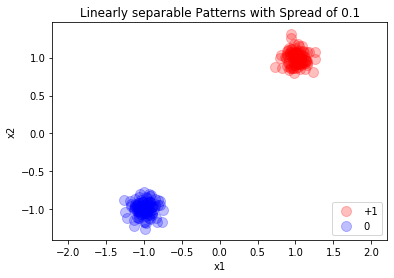

In [44]:
def generate_patterns(spread,N=2,p1=100,p2=100,option='separable',plot=False):

    # generate targets
    t=np.ones((p1+p2))# targets
    t[p1:]=0 # t2=0 targets
    x=np.zeros((p1+p2,N))
    
    # generate inputs
    if option=='separable':
        # separable targets
        x[0:p1,0:N]=1+spread*np.random.randn(N*p1).reshape(p1,N)
        x[p1:p1+p2,0:N]=-1+spread*np.random.randn(N*p2).reshape(p2,N)
    elif option=='nonseparable':
        x[0:p1,0:N]=1+spread*np.random.randn(N*p1).reshape(p1,N)
        x[0:int(p1/2),0:N]=-x[0:int(p1/2),0:N]
        x[p1:p1+p2,0:N]=-1+spread*np.random.randn(N*p2).reshape(p2,N)
        x[int(p1+p2/2):(p1+p2),0]=-x[int(p1+p2/2):(p1+p2),0]; x[p1:int(p1+p2/2),1]=-x[p1:int(p1+p2/2),1]
    elif option=='weird':
        x[0:p1,0:N]=1+spread*np.random.randn(N*p1).reshape(p1,N)
        x[0:int(p1/2),0:N]=-x[0:int(p1/2),0:N]+1.5
        x[p1:p1+p2,0:N]=-1+spread*np.random.randn(N*p2).reshape(p2,N)
        x[int(p1+p2/2):(p1+p2),0]=-x[int(p1+p2/2):(p1+p2),0]; x[p1:int(p1+p2/2),1]=-x[p1:int(p1+p2/2),1]+1
        t=np.ones((p1+p2))# targets
        t[0:int(p1/2)]=0; t[p1:int(p1+p2/2)]=0

    # make a figure
    if plot == True:
        fig,ax=plt.subplots()
        plt.title('Linearly {} Patterns with Spread of {}'.format(option,spread))
        size=100
        # scatterplot
        ax.scatter(x[t==1,0],x[t==1,1],s=size,color='red',alpha=0.25,label='+1')
        ax.scatter(x[t==0,0],x[t==0,1],s=size,color='blue',alpha=0.25,label='0')
        ax.set_xlabel("x1"); ax.set_ylabel("x2")
        ax.legend(loc='lower right')
        ax.axis('equal')  
    return x,t
    
x,t=generate_patterns(spread=0.1,N=2,p1=100,p2=100,option='separable',plot=True)


## Activity rule and cost function
Activity: 
$$
f(h)={1\over 1+e^{-h}}
$$

Log-likelihood function: 
$$
G(t^\mu|x^\mu_i,w_i)=-\sum_{\mu=1}^p\left[t^\mu\ln f(h^\mu)+(1-t^\mu)\ln(1- f(h^\mu))\right]\ , \,\,h^\mu=\sum_{i=1}^Nw_ix_i^\mu+b
$$

Log-posterior: 
$$
M(w_i|t^\mu,x^\mu_i)=G(t^\mu|x^\mu_i,w_i)+{1\over2}\alpha \sum_{i=1}^Nw_i^2
$$

In [13]:
# activity rule
b=-1; # threshold
def sigmoid(x,b,derivative=False):
    h=x+b
    out=1/(1+np.exp(-h))
    return out*(1-out) if derivative else out

def Gfunc(ww,xx,tt):
    # relative entropy between outputs and targets
    hh=sigmoid(xx.dot(ww),b)
    infhh=~np.isinf(np.log(hh))
    infhhm=~np.isinf(np.log(1-hh))
    out=-tt[infhh].dot(np.log(hh)[infhh])-(1-tt[infhhm]).dot(np.log(1-hh)[infhhm])
    return out

## Batch training using the perceptron learning rule
$$
\Delta w_i=\eta\sum_{\mu=1}^p\left(\left(t^\mu-f(h^\mu)\right)x_i^\mu-\alpha w_i\right)
$$

In [94]:
T=10000 # number of training steps
stepPlot=T/100 # take a snapshot of learning

# initialize the weights
w0=2*np.random.randn(N)
# w0=2*np.zeros(N)
print('initial weights %s' % w0)

# learning rate
eta=0.001
alpha=0.2 # weight decay

# train network
Gplot=[]; Mplot=[]; wplot=[]; yplot=[];
for step in range(T):
    if step==0: w=w0
    h=x.dot(w) # activations for all units
    y=sigmoid(h,b) # outputs
    err=t-y # error
    gr=-err.dot(x) # gradient of the log-likelihood G
    w=w-eta*(gr+alpha*w) # last term is the weight decay term
#     w[0]=w0[0] # clamp w[0] to its initial value 1
    if step % stepPlot==0:
        gtemp=Gfunc(w,x,t)
        Gplot.append(gtemp)
        Mplot.append(gtemp+0.5*alpha*w.dot(w))
        wplot.append(w)
        yplot.append(y)
    if step % (stepPlot*10) ==0:
        errorfrac=sum(abs(np.round(yplot[-1]-t)))/len(t)
        print('{a1} steps, G: {a2:.6e}, M: {a5:.6e}, errorfrac: {a6}, weights: {a3:.4},{a4:.4}'.format(a1=step,a2=gtemp,a3=w[0],a4=w[1],a5=gtemp+0.5*alpha*w.dot(w),a6=errorfrac))
    
# fraction of misclassified input patterns
print('fraction misclassified: %s' % errorfrac)

initial weights [ 0.57068979 -2.32432945]
0 steps, G: 3.579283e+02, M: 3.584458e+02, errorfrac: 0.84, weights: 0.7161,-2.159
1000 steps, G: 7.017905e+00, M: 9.600809e+00, errorfrac: 0.015, weights: 3.895,3.265
2000 steps, G: 6.262508e+00, M: 9.345335e+00, errorfrac: 0.015, weights: 4.185,3.649
3000 steps, G: 6.025446e+00, M: 9.310821e+00, errorfrac: 0.015, weights: 4.31,3.778
4000 steps, G: 5.929320e+00, M: 9.304449e+00, errorfrac: 0.015, weights: 4.369,3.829
5000 steps, G: 5.886880e+00, M: 9.303136e+00, errorfrac: 0.015, weights: 4.397,3.85
6000 steps, G: 5.867458e+00, M: 9.302852e+00, errorfrac: 0.015, weights: 4.411,3.86
7000 steps, G: 5.858419e+00, M: 9.302789e+00, errorfrac: 0.015, weights: 4.418,3.864
8000 steps, G: 5.854175e+00, M: 9.302775e+00, errorfrac: 0.015, weights: 4.421,3.866
9000 steps, G: 5.852174e+00, M: 9.302772e+00, errorfrac: 0.015, weights: 4.422,3.866
fraction misclassified: 0.015


## Plot learning schedule

Plot classification probability $P=0.25,0.75$ using the activity rule: $h=\log[P/(1-P)]$

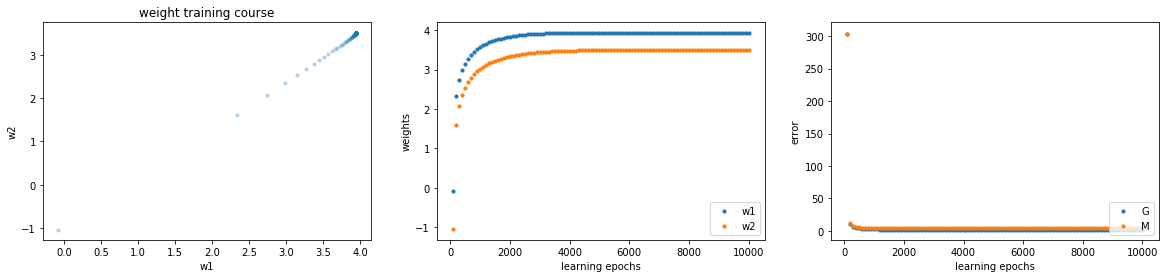

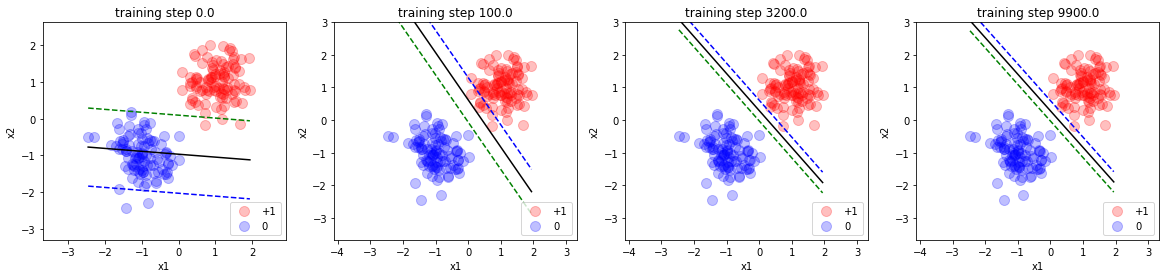

In [58]:
# first plot: evolution of the weights
fig,ax=plt.subplots(1,3,figsize=(20,4))
wplot1=np.array(wplot)
xplot=stepPlot*(np.arange(np.int(T/stepPlot))+1)
ax[0].scatter(wplot1[:,0],wplot1[:,1],s=10,alpha=0.25)
ax[0].set_xlabel('w1'); ax[0].set_ylabel('w2'); ax[0].set_title('weight training course')
for i in range(N):
    ax[1].scatter(xplot,wplot1[:,i],s=10,label='w%s' % (i+1))
ax[1].legend(loc='lower right'); ax[1].set_xlabel('learning epochs'); ax[1].set_ylabel('weights'); #ax[1].set_xscale('log')
# plot errors
ax[2].scatter(xplot,np.array(Gplot),s=10,label='G')
ax[2].scatter(xplot,np.array(Mplot),s=10,label='M')
ax[2].legend(loc='lower right'); ax[2].set_xlabel('learning epochs'); ax[2].set_ylabel('error'); #ax[1].set_xscale('log')
plt.savefig('figs/CLASS0_WeightTraining_Alpha' + '{}.pdf'.format(alpha), bbox_inches='tight')

# plot evolution of classification boundary
fig,ax=plt.subplots(1,4,figsize=(20,4))
step=[0,1,int(np.round(wplot1.shape[0]/3))-1,int(np.round(wplot1.shape[0]))-1]
h25=np.log(0.25/(1-0.25)) # activation corresponding to 0.25 probability of t=1
h75=np.log(0.75/(1-0.75))# activation corresponding to 0.75 probability of t=1
for i in range(len(step)):
    size=100
    # scatterplot
    ax[i].scatter(x[t==1,0],x[t==1,1],s=size,color='red',alpha=0.25,label='+1')
    ax[i].scatter(x[t==0,0],x[t==0,1],s=size,color='blue',alpha=0.25,label='0')
    ax[i].set_xlabel("x1"); ax[i].set_ylabel("x2")
    ax[i].legend(loc='lower right')
    ax[i].axis('equal')    
    x1=np.linspace(x[:,0].min(),x[:,0].max(),num=100)
    y0=(-b-wplot1[step[i],0]*x1)/wplot1[step[i],1]    # h=0 activation
    y1=(-b-h25-wplot1[step[i],0]*x1)/wplot1[step[i],1]    # h=+1 activation
    ym1=(-b-h75-wplot1[step[i],0]*x1)/wplot1[step[i],1]   #h=-1 activation
    ax[i].plot(x1,y0,'k'); ax[i].plot(x1,y1,'--b'); ax[i].plot(x1,ym1,'--g');
    ax[i].set_title("training step %s" % (step[i]*stepPlot))
    ax[i].set_xlim(1.5*x1[0],1.5*x1[-1]); ax[i].set_ylim(1.5*x[:,1].min(),1.5*x[:,1].max()); 
plt.savefig('figs/CLASS0_Boundaries_Alpha' + '{}.pdf'.format(alpha), bbox_inches='tight')



## Learning as inference

In the second part of this exercise we will reproduce the Figures in Chapter 41 of the MacKay book.

Plot the log-likelihood $G(t^\mu|w_i|,x^\mu_i)$ and the log-posterior $M(w_i|t^\mu,x^\mu_i)$ as functions of the weights, for fixed training data $(t^\mu,x^\mu_i)$

/Users/mazzu/opt/anaconda2/envs/MATH607/lib/python3.5/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':
/Users/mazzu/opt/anaconda2/envs/MATH607/lib/python3.5/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


w_MAP: w1=[3.9],w2=[3.5]


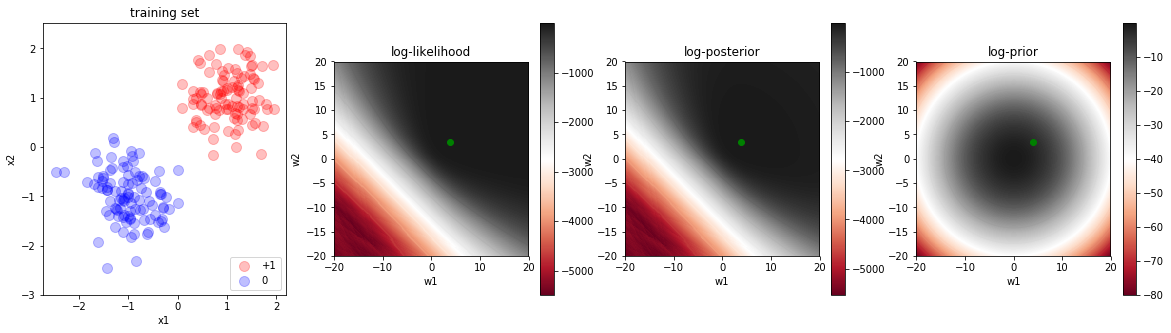

In [59]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter, LogLocator

# size of training set
ntrain=np.min([100,p1,p2])
indtrain=np.concatenate([np.arange(ntrain),np.arange(ntrain)+p1])
xplot=x[indtrain]
tplot=t[indtrain]

# alpha=0.2

# create 2d grid of (w1,w2)
Wmax=20
W1vec=np.arange(-Wmax,+Wmax,0.1)
W2vec=np.arange(-Wmax,Wmax,0.1)
W1,W2=np.meshgrid(W1vec,W2vec)
len1,len2=W1.shape

Ginference=np.zeros((len1,len2)) # log-likelihood
Minference=np.zeros((len1,len2)) # log-posterior
Priorinference=np.zeros((len1,len2)) # log-posterior

for i1 in range(len1):
    for i2 in range(len2):
        wtemp=np.array([W1[i1,i2],W2[i1,i2]])
        Ginference[i1,i2]=Gfunc(wtemp,xplot,tplot)
        Minference[i1,i2]=Ginference[i1,i2]+0.5*alpha*(wtemp.dot(wtemp))
        Priorinference[i1,i2]=0.5*alpha*(wtemp.dot(wtemp))
LLplot=-Ginference
Postplot=-Minference
Priorplot=-Priorinference

# maximum a posteriori MAP estimate
wmapind=np.where(Postplot==Postplot.max())
print('w_MAP: w1=%s,w2=%s' % (W1[wmapind],W2[wmapind]))

#=========
# PLOTS
#=========
# plot the surface
fig,ax=plt.subplots(1,4,figsize=(20,5))

# training set
size=100
# scatterplot
ax[0].scatter(xplot[0:ntrain,0],xplot[0:ntrain,1],s=size,color='red',alpha=0.25,label='+1')
ax[0].scatter(xplot[ntrain:2*ntrain,0],xplot[ntrain:2*ntrain,1],s=size,color='blue',alpha=0.25,label='0')
ax[0].set_xlabel("x1"); ax[0].set_ylabel("x2"); ax[0].set_title("training set")
ax[0].legend(loc='lower right')
ax[0].axis('equal')    

# plot log-likelihood
surf1=ax[1].imshow(LLplot,origin='lower',cmap='RdGy',extent=[np.min(W1),np.max(W1),np.min(W2),np.max(W2)])
ax[1].contour(W1,W2,LLplot,cmap='RdGy')
fig.colorbar(surf1,ax=ax[1])
ax[1].set_title('log-likelihood'); ax[1].set_xlabel('w1'); ax[1].set_ylabel('w2')
ax[1].scatter(W1[wmapind],W2[wmapind],color='g')

# plot log-posterior
surf2=ax[2].imshow(Postplot,origin='lower',cmap='RdGy',extent=[np.min(W1),np.max(W1),np.min(W2),np.max(W2)])
ax[2].contour(W1,W2,Postplot,cmap='RdGy')
fig.colorbar(surf2,ax=ax[2])
ax[2].set_title('log-posterior'); ax[2].set_xlabel('w1'); ax[2].set_ylabel('w2')
ax[2].scatter(W1[wmapind],W2[wmapind],color='g')

# plot log-prior
surf3=ax[3].imshow(Priorplot,origin='lower',cmap='RdGy',extent=[np.min(W1),np.max(W1),np.min(W2),np.max(W2)])
ax[3].contour(W1,W2,Priorplot,cmap='RdGy')
fig.colorbar(surf3,ax=ax[3])
ax[3].set_title('log-prior'); ax[3].set_xlabel('w1'); ax[3].set_ylabel('w2')
ax[3].scatter(W1[wmapind],W2[wmapind],color='g')

plt.savefig('figs/CLASS0_WeightSpace_Alpha' + '{}.pdf'.format(alpha), bbox_inches='tight')


# Exercise 1: Generalization probability

The generalization probability of classifying a new data point $(x_1,x_2)$ in the $t=1$ class given the training data $D=\{t^\mu,x_i^\mu\}_{\mu=1}^p$ is
$$
P(t=1|(x_1,x_2),D)={1\over Z_M}\int\,dw_1\,dw_2 f(\sum_{i=1,2}w_ix_i+b)e^{-M(w|D)} \ ,
$$
where $f$ is the sigmoid function with threshold $b$ and $M(w|D)$ is the log-posterior distribution of the weights given the training data $D$ calculated above. Plot $P(t=1|(x_1,x_2),D)$ given the training set and draw contours of constant probability values in the $(x_1,x_2)$.

- Compare the result for two values of the weight decay $\alpha=0.2,0.5$, and to the generalization probability $P(t=1|(x_1,x_2),w_{MAP})$ estimated directly from the maximum-a-posteriori value of the weights obtained from SGD. What is the qualitative difference between the two generalization probabilities? *Note:* Be careful about the numerical integration and check that the probability reasonably approaches its extremum values for large values of the inputs.

ValueError: could not broadcast input array from shape (200,2) into shape (200)

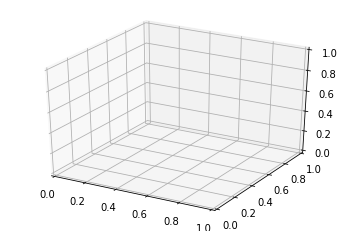

In [16]:
alpha0=0.2 # regularization
def Prob(x1,x2):
    xvec=np.array([x1,x2])
    out = integrate.dblquad(lambda w1, w2: sigmoid(np.array([w1,w2]).dot(xvec),b)*np.exp(-(Gfunc(np.array([w1,w2]),x,t)+.5*alpha0*np.array([w1,w2]).dot(np.array([w1,w2])))), np.NINF, np.inf, lambda w2: np.NINF, lambda w2: np.inf)
    return out

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x0 = np.arange(-10,10,.1)
y0 = np.arange(-10,10,.1)
z0 = Prob(x,y)
ax.plot_surface(x,y,z)
plt.show()


# Exercise 2: Stochastic gradient descent

Train the network using stochastic gradient descent (online) instead of batch. Track the evolution of the weights and the classification boundaries during learning.

# Exercise 2 Solution

Below I minutely modify the sample code to run stochastic gradient descent and use the quadratic loss function instead of relative entropy.

In [104]:
def training(x,t,T=10000,alpha=0.2,eta=0.001,stochastic=False,cost='relative entropy', Plot=True):
    stepPlot=T/100 # take a snapshot of learning
    N=x.shape[1]
    # initialize the weights
    w0=2*np.random.randn(N)
    # w0=2*np.zeros(N)
    print('initial weights %s' % w0)

    # learning rate
    #eta=0.001
    #alpha=0.2 # weight decay

    # train network
    Gplot=[]; Mplot=[]; wplot=[]; yplot=[];
    for step in range(T):
        if step==0: w=w0
        h=x.dot(w) # activations for all units
        y=sigmoid(h,b) # outputs
        if cost == 'quadratic':
            err = (t-y)*sigmoid(h,b,derivative=True) #error for quadratic loss function
        else:
            err = t-y # error for relative entropy loss function        
        if stochastic:
            rand = np.random.randint(1,x.shape[0]) #random integer for SGD
            gr=-err[rand]*x[rand] # stochastic gradient
        else:
            gr=-err.dot(x) # batch gradient
        

        w=w-eta*(gr+alpha*w) # last term is the weight decay term
    #     w[0]=w0[0] # clamp w[0] to its initial value 1
        if step % stepPlot==0:
            gtemp=Gfunc(w,x,t)
            Gplot.append(gtemp)
            Mplot.append(gtemp+0.5*alpha*w.dot(w))
            wplot.append(w)
            yplot.append(y)
        if step % (stepPlot*10) ==0:
            errorfrac=sum(abs(np.round(yplot[-1]-t)))/len(t)
            print('{a1} steps, G: {a2:.6e}, M: {a5:.6e}, errorfrac: {a6}, weights: {a3:.4},{a4:.4}'.format(a1=step,a2=gtemp,a3=w[0],a4=w[1],a5=gtemp+0.5*alpha*w.dot(w),a6=errorfrac))

    # fraction of misclassified input patterns
    print('fraction misclassified: %s' % errorfrac)
    
    if Plot:
        # first plot: evolution of the weights
        fig,ax=plt.subplots(1,3,figsize=(20,4))
        wplot1=np.array(wplot)
        xplot=stepPlot*(np.arange(np.int(T/stepPlot))+1)
        ax[0].scatter(wplot1[:,0],wplot1[:,1],s=10,alpha=0.25)
        ax[0].set_xlabel('w1'); ax[0].set_ylabel('w2'); ax[0].set_title('weight training course')
        for i in range(N):
            ax[1].scatter(xplot,wplot1[:,i],s=10,label='w%s' % (i+1))
        ax[1].legend(loc='lower right'); ax[1].set_xlabel('learning epochs'); ax[1].set_ylabel('weights'); #ax[1].set_xscale('log')
        # plot errors
        ax[2].scatter(xplot,np.array(Gplot),s=10,label='G')
        ax[2].scatter(xplot,np.array(Mplot),s=10,label='M')
        ax[2].legend(loc='lower right'); ax[2].set_xlabel('learning epochs'); ax[2].set_ylabel('error'); #ax[1].set_xscale('log')


        # plot evolution of classification boundary
        fig,ax=plt.subplots(1,4,figsize=(20,4))
        step=[0,1,int(np.round(wplot1.shape[0]/3))-1,int(np.round(wplot1.shape[0]))-1]
        h25=np.log(0.25/(1-0.25)) # activation corresponding to 0.25 probability of t=1
        h75=np.log(0.75/(1-0.75))# activation corresponding to 0.75 probability of t=1
        for i in range(len(step)):
            size=100
            # scatterplot
            ax[i].scatter(x[t==1,0],x[t==1,1],s=size,color='red',alpha=0.25,label='+1')
            ax[i].scatter(x[t==0,0],x[t==0,1],s=size,color='blue',alpha=0.25,label='0')
            ax[i].set_xlabel("x1"); ax[i].set_ylabel("x2")
            ax[i].legend(loc='lower right')
            ax[i].axis('equal')    
            x1=np.linspace(x[:,0].min(),x[:,0].max(),num=100)
            y0=(-b-wplot1[step[i],0]*x1)/wplot1[step[i],1]    # h=0 activation
            y1=(-b-h25-wplot1[step[i],0]*x1)/wplot1[step[i],1]    # h=+1 activation
            ym1=(-b-h75-wplot1[step[i],0]*x1)/wplot1[step[i],1]   #h=-1 activation
            ax[i].plot(x1,y0,'k'); ax[i].plot(x1,y1,'--b'); ax[i].plot(x1,ym1,'--g');
            ax[i].set_title("training step %s" % (step[i]*stepPlot))
            ax[i].set_xlim(1.5*x1[0],1.5*x1[-1]); ax[i].set_ylim(1.5*x[:,1].min(),1.5*x[:,1].max()); 
    return w


initial weights [-2.02970902  0.7671184 ]
0 steps, G: 3.225963e+02, M: 3.230667e+02, errorfrac: 0.94, weights: -2.028,0.7679
1000 steps, G: 1.567624e+02, M: 1.570213e+02, errorfrac: 0.5, weights: -1.096,1.178
2000 steps, G: 9.541192e+01, M: 9.561663e+01, errorfrac: 0.475, weights: -0.5192,1.333
3000 steps, G: 7.149035e+01, M: 7.167613e+01, errorfrac: 0.025, weights: -0.1597,1.354
4000 steps, G: 5.872330e+01, M: 5.890299e+01, errorfrac: 0.0, weights: 0.1021,1.337
5000 steps, G: 5.200718e+01, M: 5.218322e+01, errorfrac: 0.0, weights: 0.2898,1.295
6000 steps, G: 4.818288e+01, M: 4.835651e+01, errorfrac: 0.0, weights: 0.4283,1.246
7000 steps, G: 4.600815e+01, M: 4.617958e+01, errorfrac: 0.0, weights: 0.5312,1.197
8000 steps, G: 4.484552e+01, M: 4.501452e+01, errorfrac: 0.0, weights: 0.6079,1.149
9000 steps, G: 4.378114e+01, M: 4.394999e+01, errorfrac: 0.0, weights: 0.6725,1.112
fraction misclassified: 0.0


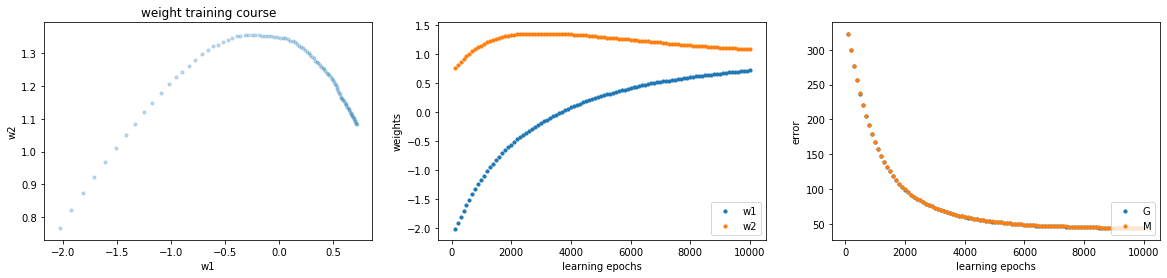

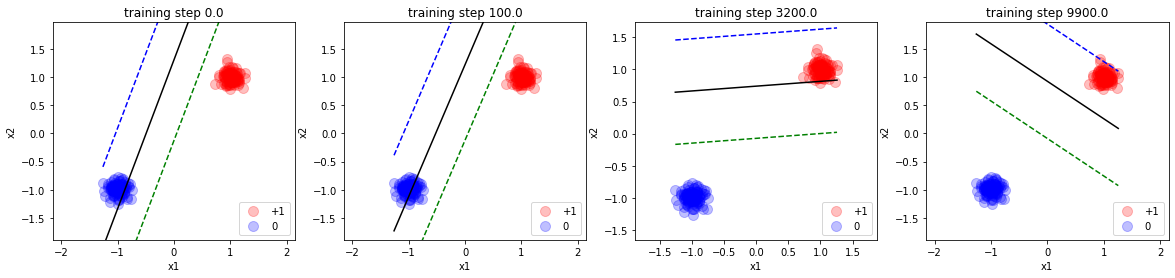

In [94]:
training(x,t,stochastic=True)

# Exercise 3: Quadratic loss function

Train the network using the quadratic loss function $M(t^\mu|w_i|,x^\mu_i)={1\over 2}\sum_{\mu=1}^p(t^\mu-f(h^\mu))^2+{1\over2}\alpha \sum_{i=1}^Nw_i^2$

# Exercise 3 Solution

initial weights [-0.80111395 -0.34676536]
0 steps, G: 2.971316e+02, M: 2.972029e+02, errorfrac: 0.97, weights: -0.7793,-0.3253
1000 steps, G: 8.755655e+00, M: 9.390319e+00, errorfrac: 0.0, weights: 1.609,1.938
2000 steps, G: 7.577561e+00, M: 8.264809e+00, errorfrac: 0.0, weights: 1.719,1.98
3000 steps, G: 7.370247e+00, M: 8.066809e+00, errorfrac: 0.0, weights: 1.76,1.967
4000 steps, G: 7.327076e+00, M: 8.024973e+00, errorfrac: 0.0, weights: 1.785,1.948
5000 steps, G: 7.317929e+00, M: 8.015683e+00, errorfrac: 0.0, weights: 1.803,1.931
6000 steps, G: 7.316084e+00, M: 8.013517e+00, errorfrac: 0.0, weights: 1.817,1.916
7000 steps, G: 7.315791e+00, M: 8.012962e+00, errorfrac: 0.0, weights: 1.829,1.904
8000 steps, G: 7.315806e+00, M: 8.012793e+00, errorfrac: 0.0, weights: 1.839,1.895
9000 steps, G: 7.315869e+00, M: 8.012729e+00, errorfrac: 0.0, weights: 1.846,1.887
fraction misclassified: 0.0


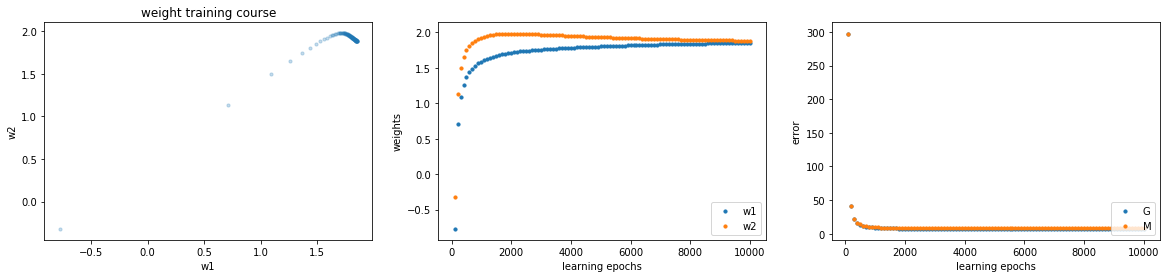

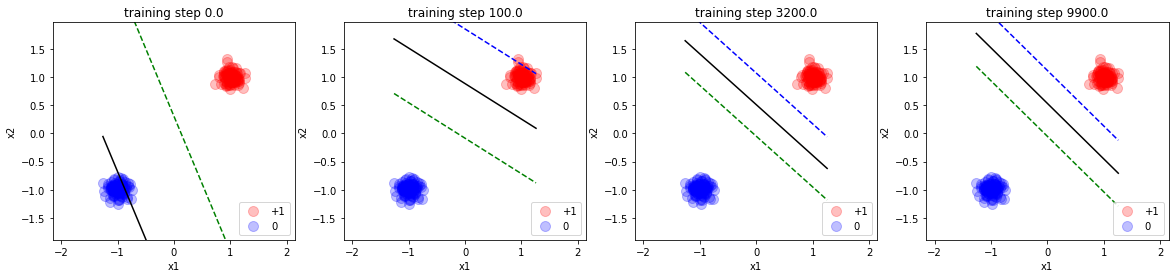

In [96]:
training(x,t,cost = 'quadratic')

# Exercise 4: Generalization ability and weight decay

To understand the role of weight decay in preventing overfitting, we will perform the following exercise. Let us train the perceptron  on a fixed set of *easy-to-classify* patterns, and then we will estimate the generalization performance on a variety of patterns. We will examine which values of the weight decay term $\alpha$ help generalizing. 

Generate $p_1=p_2=200$ patterns per class of the *trapezoid* kind in N=100 dimensions, with fixed spread of 0.1. Use this *training set* for training the perceptron with stochastic gradient descent with eta=0.01, for different values of $\alpha=0,0.01,0.1,0.2$. Now generate a series of 10 different *test sets* of the same trapezoid kind. In each test set, generate $p_1=p_2=200$ patterns per class with fixed spread$=0.1,0.5,1,2$. For each test set, estimate the fraction of correctly classified patterns ("hits") in the corresponding test set, using the different perceptrons trained for different values of $\alpha$. Report average test-set classification accuracy (mean $\pm$ standard deviation of the hits).

What do you find? Which values of $\alpha$ are more beneficial for obtaining a good classification accuracy for increasingly noisy patterns?

# Exercise 3 solution

initial weights [-0.64667142 -0.8934169  -1.48808451 -0.21080917 -0.50081501  0.92099354
  1.310712    0.21661525  4.18628725 -3.4627759  -0.06222445  2.05431363
 -2.56739473 -1.63886512  3.22439975  0.99803146  2.52480314 -0.82294244
  2.00909773 -0.51456971 -1.638871    0.55056817 -0.15660743 -0.79798661
  0.09625862  0.71365606  0.75986698 -2.96691112 -0.12496615  1.25282047
  0.96279061  2.28466418  0.57242742  0.72794193  0.6457105  -0.50573997
 -1.13862452  0.73940497 -0.91166604 -1.76394139  2.58600035 -1.78674708
 -1.10539828  1.79772444  3.57365729  2.80919253  0.08750696  1.10336886
 -3.8438247   0.19645095  3.17313712 -4.3062102   1.75857227 -0.23010651
 -0.21971447 -1.15667965 -2.58250714  2.26694847  0.65424672  2.00297391
  2.05965885 -5.02574278 -0.76776778 -0.19037309  2.13268872  2.56418621
 -2.00452025  0.80467593  1.14828062  1.708426   -2.16665638 -0.01584188
  2.28592165 -0.06917835  0.76615576  0.61829518  0.21576984 -0.82916568
 -1.83804149 -1.51578193  4.7596531

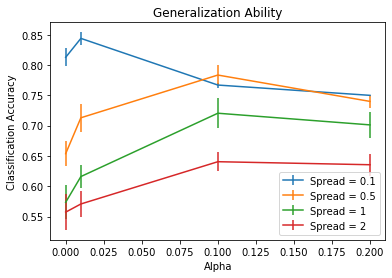

In [119]:
def testing(xtest,ttest,w0):
    h=xtest.dot(w0)
    y=sigmoid(h,b)
    return (1-sum(abs(np.round(y-ttest)))/len(ttest))


alphas=[0.0,0.01,0.1,0.2]
spreads=[0.1,0.5,1,2]
epochs=10000
eta=0.01

# generate training data
xtrain, ttrain = generate_patterns(p1=200,p2=200, N=100, option='weird', spread=0.1, plot=False)

# train perceptrons, record weights
perceptrons = []
for alph in alphas:
    w = training(xtrain,ttrain,T=epochs,eta=eta,alpha=alph,stochastic=True,Plot=False)
    perceptrons.append(w)


fig,ax=plt.subplots()
for spr in spreads:
    means = []
    errors = []
    # generate testing data
    xtest = []
    ttest = []
    for j in range(10):
        x, t = generate_patterns(p1=200,p2=200, N=100, option='weird', spread=spr, plot=False)
        xtest.append(x)
        ttest.append(t)
    # test perceptrops for different alphas
    for i in range(len(alphas)):
        tests = []
        for j in range(10):
            correctfrac = testing(xtest[j],ttest[j],perceptrons[i])
            tests.append(correctfrac)
        means.append(np.mean(tests)) # mean classification accuracy over 10 test sets with fixed spread
        errors.append(np.std(tests)) # standard deviation of above
    ax.errorbar(alphas,means,yerr=errors,label='Spread = {}'.format(spr)) # plot classification accuracy vs alpha with error
plt.xlabel('Alpha')
plt.ylabel('Classification Accuracy')
plt.title('Generalization Ability')
plt.legend()
plt.show()
        

From the plot above, I conclude that alpha = .100 is the most tolerant of increasingly noisy data. The drop in classification accuracy is less extreme than with the small values of alpha (0, .01) and slightly less than with alpha= .2.

# Exercise 5: K-fold cross-validation for model selection

Generate $p_1=p_2=1000$ patterns per class with fixed spread. Split the data in K=10 balanced partitions $S_{test}^k,\,k=1,\ldots,K$ where each partition contains $1000/(2\times K)$ patterns per class, drawn randomly without substitution: denote each partition set as "hold-out set" or "test set". For each partition, train a perceptron with stochastic gradient descent to perform the classification task using the K-1 folds, $S_{train}^k,\,k=1,\ldots,K$ (training set), and estimate the fraction of correctly classified patterns ("hits") in the corresponding test set. Report across-folds average test-set classification accuracy (mean $\pm$ standard deviation).

Plot classification accuracy in the (spread,$\alpha$) plane, in the same range as in the previous exercise.